# ObamaStarter

In this notebook, we will be building a predictive model to forecast the results of primary races in which Obama and Clinton both took part in the 2008 primary. We will use linear regression, regularized linear regression, and decision trees to forecast future primary results. We will also be interpreting these models in order to generate potentially useful insights for either the Obama or Clinton campaign to increase their chances of becoming the Democratic presidential nominee.

## Import Packages

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
import statsmodels.formula.api as smf

from patsy import dmatrices, dmatrix, build_design_matrices

import math

In [187]:
def accuracy(y_true, y_pred):
    """Function that returns a table showing RMSE and MAE."""
    acc_df = pd.DataFrame(data = {"RMSE": [mean_squared_error(y_true, y_pred)**(1/2)],
                                  "MAE": [mean_absolute_error(y_true, y_pred)],
                                  "R^2": [r2_score(y_true, y_pred)]})
    return acc_df

In [2]:
# This sets some nicer defaults for plotting.
# This must be run in a separate cell from importing matplotlib due to a bug.
params = {'legend.fontsize': 'large',
          'figure.figsize': (11.0, 11.0),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}
mpl.rcParams.update(params)

# This makes it so that the pandas dataframes don't get truncated horizontally.
pd.options.display.max_columns = 200

## Load, Inspect, Clean, and Shape Data

We will load in our data set. However, this data set includes both past data and data on future primaries. The past data includes the candidates performance in the primaries that have already been completed. The primaries that are yet to be completed do not have this data.

In [3]:
elect_df = pd.read_csv("Obama.csv")

In [4]:
## ADD HOMESTATE VARIABLE

elect_df['ObamaHomeState'] = np.where((elect_df['State'] == 'IL') | (elect_df['State'] == 'HI') , 1, 0)
elect_df['ClintonHomeState'] = np.where((elect_df['State'] == 'NY') | (elect_df['State'] == 'AK') , 1, 0)

What are the columns of the dataset?

In [6]:
elect_df.columns

Index(['County', 'State', 'Region', 'FIPS', 'ElectionDate', 'ElectionType',
       'TotalVote', 'Clinton', 'Obama', 'MalesPer100Females', 'AgeBelow35',
       'Age35to65', 'Age65andAbove', 'White', 'Black', 'Asian',
       'AmericanIndian', 'Hawaiian', 'Hispanic', 'HighSchool', 'Bachelors',
       'Poverty', 'IncomeAbove75K', 'MedianIncome', 'AverageIncome',
       'UnemployRate', 'ManfEmploy', 'SpeakingNonEnglish', 'Medicare',
       'MedicareRate', 'SocialSecurity', 'SocialSecurityRate',
       'RetiredWorkers', 'Disabilities', 'DisabilitiesRate', 'Homeowner',
       'SameHouse1995and2000', 'Pop', 'PopDensity', 'LandArea', 'FarmArea',
       'ObamaHomeState', 'ClintonHomeState'],
      dtype='object')

How many rows and columns do we have?

In [7]:
elect_df.shape

(2868, 43)

In [8]:
temp=elect_df.corr()
x=temp.values>.5
for column in temp.columns:
    for i, row in enumerate(temp[column]):
        if(row>.6 and row<.99):
            print(column, temp.index[i], row)

TotalVote Clinton 0.9689803301576273
TotalVote Obama 0.968552955154259
TotalVote Medicare 0.861595004038574
TotalVote SocialSecurity 0.8520693087605318
TotalVote RetiredWorkers 0.8466494290483249
TotalVote Disabilities 0.8271100934512584
TotalVote Pop 0.8810694116677008
Clinton TotalVote 0.9689803301576273
Clinton Obama 0.8782424963615487
Clinton Medicare 0.8591620669147361
Clinton SocialSecurity 0.8447631151969811
Clinton RetiredWorkers 0.8413795847234364
Clinton Disabilities 0.8488974710079441
Clinton Pop 0.8837195980112627
Obama TotalVote 0.968552955154259
Obama Clinton 0.8782424963615487
Obama Medicare 0.8018473347647421
Obama SocialSecurity 0.7966884415841333
Obama RetiredWorkers 0.7894154449742679
Obama Disabilities 0.7523622462050433
Obama Pop 0.8176884596538891
Age65andAbove MedicareRate 0.8045618865972749
Age65andAbove SocialSecurityRate 0.8693093407938414
Hispanic SpeakingNonEnglish 0.9280476061068481
HighSchool Bachelors 0.6532869847051311
HighSchool MedianIncome 0.641264934

In [9]:
def summarize_dataframe(df):
    """Summarize a dataframe, and report missing values."""
    missing_values = pd.DataFrame({'Variable Name': df.columns,
                                   'Data Type': df.dtypes,
                                   'Missing Values': df.isnull().sum(),
                                   'Unique Values': [df[name].nunique() for name in df.columns]}
                                 ).set_index('Variable Name')
    with pd.option_context("display.max_rows", 1000):
        display(pd.concat([missing_values, df.describe(include='all').transpose()], axis=1).fillna(""))

What are the names of the variables in the data frame? How many values are missing? Use our self defined `summarize_dataframe` function to find out the number of NA's for each variable.

In [10]:
summarize_dataframe(elect_df)

,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
County,object,0,1691,2868.0,1691,Washington,30,,,,,,,
State,object,0,46,2868.0,46,TX,251,,,,,,,
Region,object,0,4,2868.0,4,South,1419,,,,,,,
FIPS,int64,0,2868,2868.0,,,,31029.039052,15411.398662,1001.0,18102.5,30110.0,46123.5,56045.0
ElectionDate,object,0,18,2868.0,18,2/5/2008,1128,,,,,,,
ElectionType,object,0,2,2868.0,2,Primary,2558,,,,,,,
TotalVote,float64,1131,1490,1737.0,,,,12863.7962,53071.884245,13.0,732.0,2330.0,6418.0,1413869.0
Clinton,float64,1131,1338,1737.0,,,,5973.738054,25402.029497,4.0,329.0,1106.0,3200.0,771700.0
Obama,float64,1131,1314,1737.0,,,,6178.122625,27477.231157,4.0,254.0,878.0,2749.0,743686.0
MalesPer100Females,float64,0,391,2868.0,,,,99.081729,9.276792,76.2,94.9,97.6,100.5,200.9


We can see that we have some missing data. The missing data falls into two categories. First, we are missing data on `TotatVote`, `Clinton`, and `Obama`. These values are intended to be missing. They are data that we do not have yet, and this is what we will be trying to forecast. Often times, you will have two separate data sets, one that is intended for training that has all of the columns of data filled in and another for testing that is missing the prediction data. In this case, those two datasets are combined into one `.csv` file.

Let's deal with this combined data first. We will manually separate out the training and the testing sets.

## Creating Training and Testing Sets

We will create two separate data sets from the data in `elect_df`. We will create a _training_ data set and a _testing_ data set. The training data set will consist of elections that have already happened; the testing of those which are yet to come. In order to do this split, we need to be able to operate on _dates_.

The below code converts the `ElectionDate` column from just an arbitrary string (in the view of pandas) to something that means dates ordered in time.

In [11]:
elect_df["ElectionDate"] = pd.to_datetime(elect_df["ElectionDate"])

Once we have this, we can take all of the data before February 19, 2008 as our training set, and all of the data after that point as our testing set.

In [12]:
elect_df_train = elect_df[elect_df["ElectionDate"] < pd.to_datetime("2/19/2008")].copy()

In [13]:
elect_df_test = elect_df[elect_df["ElectionDate"] >= pd.to_datetime("2/19/2008")].copy()

Note that above we did something a little strange. We called `.copy()` on the pandas dataframe. Sometimes when we are creating new dataframes from existing dataframes, we can end up "linking" the two dataframes instead of creating a new dataframe. This can cause some weird issues. Specifically, we can change something in one dataframe, and it will actually change it in the other dataframe because in the background they are the same dataframe.

In order to avoid this, we are explicitly copying the dataframe. This tells python that we do not want these dataframes linked in the background. This often is not strictly necessary, but if you do not do this, it can lead to weird problems later on.

Now, we will create some possible dependent variables (things we might like to predict in a regression using the demographic information). These variables directly become a part of our data set `elect_df_train` dataframe.

In [14]:
elect_df_train["Obama_margin"] = elect_df_train["Obama"] - elect_df_train["Clinton"]
elect_df_train["Obama_margin_percent"] = elect_df_train["Obama_margin"] / elect_df_train["TotalVote"]
elect_df_train["Obama_wins"] = elect_df_train["Obama_margin"] > 0

Let's take a look and see that these variables are part of our dataframe now. You can also see that the "Data Type" of `ElectionDate` has changed. It is now a `datetime64[ns]` object because we told pandas that it is a date.

In [15]:
summarize_dataframe(elect_df_train)

/tmp/ipykernel_55/2697573813.py:9: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(pd.concat([missing_values, df.describe(include='all').transpose()], axis=1).fillna(""))


,Data Type,Missing Values,Unique Values,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
County,object,0,1138,1737.0,1138,Washington,19,NaT,NaT,,,,,,,
State,object,0,30,1737.0,30,GA,159,NaT,NaT,,,,,,,
Region,object,0,4,1737.0,4,South,811,NaT,NaT,,,,,,,
FIPS,int64,0,1737,1737.0,,,,NaT,NaT,25907.716753,15270.200219,1001.0,13157.0,25007.0,36095.0,53077.0
ElectionDate,datetime64[ns],0,9,1737.0,9,2008-02-05 00:00:00,1128,2008-01-03,2008-02-12,,,,,,,
ElectionType,object,0,2,1737.0,2,Primary,1454,NaT,NaT,,,,,,,
TotalVote,float64,0,1490,1737.0,,,,NaT,NaT,12863.7962,53071.884245,13.0,732.0,2330.0,6418.0,1413869.0
Clinton,float64,0,1338,1737.0,,,,NaT,NaT,5973.738054,25402.029497,4.0,329.0,1106.0,3200.0,771700.0
Obama,float64,0,1314,1737.0,,,,NaT,NaT,6178.122625,27477.231157,4.0,254.0,878.0,2749.0,743686.0
MalesPer100Females,float64,0,344,1737.0,,,,NaT,NaT,99.24669,9.794664,76.2,94.9,97.6,100.7,200.9


Now we have a data set just of the previous primary elections (notice that we do not have any missing values for `Clinton`, `Obama`, or `TotalVote`).

## Split into `smaller_train` and `validation` Data Sets

However, we are not done yet manipulating our data. A best practice in machine learning is to further split up the training set into a smaller training set and a validation set. You can compare the performance of candidate models (each trained on the smaller training set) on the validation set. This `smaller_train` data set becomes our laboratory to test out different modeling decisions and try them out on the `validation` data set.

The following code randomly splits your training set into a smaller training set (75% of the training data) and a validation set (25% of the training data).

In [16]:
elect_df_smaller_train, elect_df_validation = train_test_split(elect_df_train, test_size=.25, random_state=201)

The test (or _validation_) data set is 25% of the original data. We also include the parameter `random_state=201` in the function call. This is because the function `train_test_split` randomly splits your data. This is good practice. However, if we let it randomly split our data, everytime we run our code something different will happen. We pass an initial _seed_ to the randomness generator in the function which makes the function give us _the same random split_ each time. This helps us with reproducibility with the code.

In [17]:
summarize_dataframe(elect_df_smaller_train)

/tmp/ipykernel_55/2697573813.py:9: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(pd.concat([missing_values, df.describe(include='all').transpose()], axis=1).fillna(""))


,Data Type,Missing Values,Unique Values,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
County,object,0,921,1302.0,921,Franklin,15,NaT,NaT,,,,,,,
State,object,0,30,1302.0,30,GA,120,NaT,NaT,,,,,,,
Region,object,0,4,1302.0,4,South,608,NaT,NaT,,,,,,,
FIPS,int64,0,1302,1302.0,,,,NaT,NaT,25818.745008,15254.098491,1001.0,13163.5,24026.0,36086.5,53077.0
ElectionDate,datetime64[ns],0,9,1302.0,9,2008-02-05 00:00:00,836,2008-01-03,2008-02-12,,,,,,,
ElectionType,object,0,2,1302.0,2,Primary,1094,NaT,NaT,,,,,,,
TotalVote,float64,0,1137,1302.0,,,,NaT,NaT,13392.989247,59063.233132,13.0,692.75,2305.0,6417.25,1413869.0
Clinton,float64,0,1041,1302.0,,,,NaT,NaT,6143.649002,28083.659257,4.0,306.75,1080.5,3108.25,771700.0
Obama,float64,0,1048,1302.0,,,,NaT,NaT,6504.599846,30755.114644,4.0,249.0,864.5,2747.0,743686.0
MalesPer100Females,float64,0,309,1302.0,,,,NaT,NaT,99.207527,9.598902,76.2,94.8,97.5,100.8,200.9


In our smaller training set, we now have 1302 data points. The other data is either in the test set or the validation set.

We also have missing data on a number of the numeric demographic data. However, even `ManfEmploy` which has the most missing data only has 133 missing data points out of a total of 1302 rows. Therefore, we probably don't want to just throw any of this data away.

We need to _impute_ the missing values. There are a number of possible strategies, but the most common is to just assume that the missing value is equal to the average of the non-missing values. This is, in some ways, a very safe assumption. If the data is missing just because someone forgot to input it, then there is no reason to believe that the data is either above or below average, so we should just assume it is average.

However, this strategy may not make sense with some data. Think about what else you might want to do.

To do the imputation, we will use an _object_ from the `sklearn` library called a _Transformer_. These transformers, unsurprisingly, transform data. We will see this pattern a lot when working with objects from `sklearn`, so it is worthwhile to understand how this thing works.

First, we create the `SimpleImputer` and we tell it what kind of imputer we would like it to be. Below, we create one called `imputer` and we tell it that missing values are `np.nan` (a common way for numpy and pandas to represent missing values) and we tell it to impute using the mean of existing data. Note that we don't actually give it the data yet.

In [18]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

In order to impute anything, we need to `fit` the imputer. The imputer needs to know what the mean of all of the existing data is, so we give it the data set, and we let it learn the mean. After it has been fitted, we can use it to actually transform the data.

In [19]:
imputer.fit(elect_df_smaller_train.loc[:, "MalesPer100Females":"FarmArea"])

SimpleImputer()

Once we have `fit` the imputer (note that we fit all of the numeric rows at once, we don't need an imputer per column), we can then _transform_ the data.

In [20]:
elect_df_smaller_train.loc[:, "MalesPer100Females":"FarmArea"] = imputer.transform(elect_df_smaller_train.loc[:, "MalesPer100Females":"FarmArea"])

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


You likely got a warning above. This is due to a bug in `train_test_split` not letting pandas know that things are a copy. You can ignore it. Note that this is not an error, and the code does run just fine.

Notice how we were able to fix all of the missing values at once with the syntax `.loc[:, "MalesPer100Females":"FarmArea"]`. This tells the dataframe that we want all columns between `MalesPer100Females` and `FarmArea`. If you check back at the dataframe summary you will see that these are all of our numeric columns, so it should be everything. You need to be careful when using this syntax because you don't want to accidentally include columns that you don't intend to. However, it can be a convenient way to get a bunch of columns without explicitly writing down all of the names.

Run the summary function again. Now you see that no demographic/county columns have NA entries.

In [21]:
summarize_dataframe(elect_df_smaller_train)

/tmp/ipykernel_55/2697573813.py:9: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(pd.concat([missing_values, df.describe(include='all').transpose()], axis=1).fillna(""))


,Data Type,Missing Values,Unique Values,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
County,object,0,921,1302.0,921,Franklin,15,NaT,NaT,,,,,,,
State,object,0,30,1302.0,30,GA,120,NaT,NaT,,,,,,,
Region,object,0,4,1302.0,4,South,608,NaT,NaT,,,,,,,
FIPS,int64,0,1302,1302.0,,,,NaT,NaT,25818.745008,15254.098491,1001.0,13163.5,24026.0,36086.5,53077.0
ElectionDate,datetime64[ns],0,9,1302.0,9,2008-02-05 00:00:00,836,2008-01-03,2008-02-12,,,,,,,
ElectionType,object,0,2,1302.0,2,Primary,1094,NaT,NaT,,,,,,,
TotalVote,float64,0,1137,1302.0,,,,NaT,NaT,13392.989247,59063.233132,13.0,692.75,2305.0,6417.25,1413869.0
Clinton,float64,0,1041,1302.0,,,,NaT,NaT,6143.649002,28083.659257,4.0,306.75,1080.5,3108.25,771700.0
Obama,float64,0,1048,1302.0,,,,NaT,NaT,6504.599846,30755.114644,4.0,249.0,864.5,2747.0,743686.0
MalesPer100Females,float64,0,309,1302.0,,,,NaT,NaT,99.207527,9.598902,76.2,94.8,97.5,100.8,200.9


The one thing you need to be careful of is that we haven't imputed values for our _validation_ or _test_ data yet. At this point, we could not use any model we built to predict on these other datasets because they will have missing values in them, so we need to impute the missing values for them as well. However, we need to be sure we use _the same imputer_ to impute data for those. I.e., we don't refit the imputer. Why is this so important? What might go wrong if we don't?

In [22]:
elect_df_validation.loc[:, "MalesPer100Females":"FarmArea"] = imputer.transform(elect_df_validation.loc[:, "MalesPer100Females":"FarmArea"])

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


Note that we have only imputed on our validation data set so far becuase at this stage of the process, our validation data set is a stand in for our testing data. We will impute on our testing data after we have chosen our models because at that point we will re-fit the imputer on the entire training data.

Note that we have only imputed on our validation data set so far becuase at this stage of the process, our validation data set is a stand in for our testing data. We will impute on our testing data after we have chosen our models because at that point we will re-fit the imputer on the entire training data.

Note that we have only imputed on our validation data set so far becuase at this stage of the process, our validation data set is a stand in for our testing data. We will impute on our testing data after we have chosen our models because at that point we will re-fit the imputer on the entire training data.

In [23]:
## Check the datasets

elect_df_train.shape # 1737 total observations in the training data
elect_df_validation.shape # 435 observations without percent margin


(435, 46)

In [24]:
## Add the variables that we determined are important

elect_df_train.head()

,County,State,Region,FIPS,ElectionDate,ElectionType,TotalVote,Clinton,Obama,MalesPer100Females,AgeBelow35,Age35to65,Age65andAbove,White,Black,Asian,AmericanIndian,Hawaiian,Hispanic,HighSchool,Bachelors,Poverty,IncomeAbove75K,MedianIncome,AverageIncome,UnemployRate,ManfEmploy,SpeakingNonEnglish,Medicare,MedicareRate,SocialSecurity,SocialSecurityRate,RetiredWorkers,Disabilities,DisabilitiesRate,Homeowner,SameHouse1995and2000,Pop,PopDensity,LandArea,FarmArea,ObamaHomeState,ClintonHomeState,Obama_margin,Obama_margin_percent,Obama_wins
0,Adair,IA,Midwest,19001,2008-01-03,Caucuses,75.0,22.0,24.0,96.7,37.7,40.3,21.9,99.2,0.1,0.5,NaN,0.0,0.8,87.8,11.2,9.7,8.6,39568.0,29222.0,3.2,12.916739,2.0,1551.0,19735.0,1825.0,23222.0,1230.0,90.0,1145.0,75.0,66.0,7714,13.5,570.0,373.0,0,0,2.0,0.026667,True
1,Adams,IA,Midwest,19003,2008-01-03,Caucuses,50.0,18.0,7.0,96.8,37.1,40.8,22.1,99.2,NaN,0.2,0.5,0.0,0.6,84.5,12.0,10.6,7.8,35296.0,27297.0,4.6,6.964421,1.6,978.0,22936.0,1110.0,26032.0,720.0,78.0,1829.0,74.7,65.4,4192,9.9,425.0,238.0,0,0,-11.0,-0.220000,False
2,Allamakee,IA,Midwest,19005,2008-01-03,Caucuses,80.0,25.0,33.0,104.5,41.5,40.8,17.7,99.0,0.2,0.2,0.3,0.0,6.9,81.4,14.4,10.8,10.7,36822.0,25579.0,4.6,16.473466,8.2,2838.0,19294.0,3270.0,22231.0,2245.0,186.0,1265.0,76.4,64.1,14796,23.1,659.0,326.0,0,0,8.0,0.100000,True
3,Appanoose,IA,Midwest,19007,2008-01-03,Caucuses,60.0,17.0,10.0,94.0,42.0,39.2,18.9,98.5,0.7,0.4,0.1,0.0,1.1,81.4,12.2,14.9,6.6,31764.0,23705.0,5.4,15.080881,2.5,3072.0,22479.0,3415.0,24989.0,2050.0,453.0,3315.0,74.0,60.2,13422,27.0,516.0,236.0,0,0,-7.0,-0.116667,False
4,Audubon,IA,Midwest,19009,2008-01-03,Caucuses,48.0,16.0,17.0,94.7,37.4,40.2,22.5,99.3,0.2,0.2,0.1,0.0,0.6,82.5,12.3,9.2,9.7,38941.0,31100.0,4.1,8.333333,2.7,1472.0,22797.0,1740.0,26947.0,1150.0,79.0,1223.0,79.2,70.4,6278,14.2,444.0,261.0,0,0,1.0,0.020833,True


In [173]:
x=elect_df_train.loc[:,elect_df_train.columns!="Obama_margin_percent"]
y=elect_df_train.loc[:,elect_df_train.columns=="Obama_margin_percent"]
elect_df_train.columns

Index(['County', 'State', 'Region', 'FIPS', 'ElectionDate', 'ElectionType',
       'TotalVote', 'Clinton', 'Obama', 'MalesPer100Females', 'AgeBelow35',
       'Age35to65', 'Age65andAbove', 'White', 'Black', 'Asian',
       'AmericanIndian', 'Hawaiian', 'Hispanic', 'HighSchool', 'Bachelors',
       'Poverty', 'IncomeAbove75K', 'MedianIncome', 'AverageIncome',
       'UnemployRate', 'ManfEmploy', 'SpeakingNonEnglish', 'Medicare',
       'MedicareRate', 'SocialSecurity', 'SocialSecurityRate',
       'RetiredWorkers', 'Disabilities', 'DisabilitiesRate', 'Homeowner',
       'SameHouse1995and2000', 'Pop', 'PopDensity', 'LandArea', 'FarmArea',
       'ObamaHomeState', 'ClintonHomeState', 'Obama_margin',
       'Obama_margin_percent', 'Obama_wins'],
      dtype='object')

In [25]:
lm_1 = smf.ols(formula='Obama_margin_percent ~ Region + ObamaHomeState + ClintonHomeState + MalesPer100Females + MedianIncome + UnemployRate + Age65andAbove+ White + Asian + Black + Hispanic + AmericanIndian + HighSchool + Poverty + PopDensity + Homeowner + FarmArea', data=elect_df_train).fit()
lm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Obama_margin_percent   R-squared:                       0.702
Model:                              OLS   Adj. R-squared:                  0.698
Method:                   Least Squares   F-statistic:                     188.6
Date:                  Wed, 10 Nov 2021   Prob (F-statistic):               0.00
Time:                          01:42:01   Log-Likelihood:                 581.01
No. Observations:                  1544   AIC:                            -1122.
Df Residuals:                      1524   BIC:                            -1015.
Df Model:                            19                                         
Covariance Type:              nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -4.2956      0.591     -7.264      0.000      -5.456      -3.136
Region[T.Northeast]    -0.0318      0.025     -1.298      0.195      -0.080       0.016
Region[T.South]        -0.2026      0.015    -13.365      0.000      -0.232      -0.173
Region[T.West]          0.1609      0.017      9.309      0.000       0.127       0.195
ObamaHomeState          0.1769      0.020      8.863      0.000       0.138       0.216
ClintonHomeState       -0.2471      0.031     -7.933      0.000      -0.308      -0.186
MalesPer100Females  -3.892e-06      0.000     -0.008      0.993      -0.001       0.001
MedianIncome        -4.154e-06   1.06e-06     -3.932      0.000   -6.23e-06   -2.08e-06
UnemployRate           -0.0244      0.003     -7.150      0.000      -0.031      -0.018
Age65andAbove          -0.0081      0.002     -5.158      0.000      -0.011      -0.005
White                   0.0385      0.006      6.702      0.000       0.027       0.050
Asian                   0.0391      0.007      5.387      0.000       0.025       0.053
Black                   0.0582      0.006     10.292      0.000       0.047       0.069
Hispanic                0.0010      0.001      1.751      0.080      -0.000       0.002
AmericanIndian          0.0472      0.006      7.323      0.000       0.035       0.060
HighSchool              0.0123      0.001     11.623      0.000       0.010       0.014
Poverty                -0.0223      0.002     -9.137      0.000      -0.027      -0.018
PopDensity          -5.739e-05   1.43e-05     -4.022      0.000   -8.54e-05   -2.94e-05
Homeowner               0.0007      0.001      0.830      0.407      -0.001       0.002
FarmArea            -6.724e-05   1.66e-05     -4.046      0.000   -9.98e-05   -3.46e-05
==============================================================================
Omnibus:                       45.348   Durbin-Watson:                   1.325
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.398
Skew:                          -0.173   Prob(JB):                     1.42e-20
Kurtosis:                       4.140   Cond. No.                     5.81e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.81e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [184]:


## Create the tree regression


# Create matrices (with new sample)
y_tree, X_tree = dmatrices('Obama_margin_percent ~ 0 + Region + ObamaHomeState + ClintonHomeState + MalesPer100Females + MedianIncome + UnemployRate + Age65andAbove+ White + Asian + Black + Hispanic + AmericanIndian + HighSchool + Poverty + PopDensity + Homeowner + FarmArea', elect_df_smaller_train, return_type="dataframe")

# Create tree object with tuning parameters
dt_tuned = DecisionTreeRegressor(min_samples_leaf=10, max_depth=100, max_features="auto", random_state=2020)

# Fit data to decision tree
dt_tuned.fit(X_tree,y_tree)

# Validation tree
X_validation_tree = build_design_matrices([X_tree.design_info], elect_df_validation, return_type="dataframe")[0]

# Decision tree predictions
dt_pred = dt_tuned.predict(X_validation_tree)

# Check accuracy
result=accuracy(dt_pred, elect_df_validation["Obama_margin_percent"])
result=(result.iloc[0,0])
temp={"depth":[100], "split":[10], "RMSE":[result]}
answer=pd.DataFrame(data=temp)
results=results.append(answer)
results

RMSE,MAE,R^2
0.181240,0.134597,0.582739


,depth,split,RMSE
0,100,10,0.18124


In [255]:
## Tree regression loops through tuning parameters

# Set tuning arrays

results=pd.DataFrame(columns=["depth","split","RMSE"])
depth_params=[*range(1,21,1)]
samples_params=[*range(10,200,5)]

# Loops

for i in depth_params:
    for j in samples_params:
        # Create matrices (with new sample)
        y_tree, X_tree = dmatrices('Obama_margin_percent ~ 0 + Region + ObamaHomeState + ClintonHomeState + MalesPer100Females + MedianIncome + UnemployRate + Age65andAbove+ White + Asian + Black + Hispanic + AmericanIndian + HighSchool + Poverty + PopDensity + Homeowner + FarmArea', elect_df_smaller_train, return_type="dataframe")

        # Create tree object with tuning parameters
        dt_tuned = DecisionTreeRegressor(min_samples_leaf=j, max_depth=i, max_features="auto", random_state=2020)

        # Fit data to decision tree
        dt_tuned.fit(X_tree,y_tree)

        # Validation tree
        X_validation_tree = build_design_matrices([X_tree.design_info], elect_df_validation, return_type="dataframe")[0]

        # Decision tree predictions
        dt_pred = dt_tuned.predict(X_validation_tree)

        # Check accuracy
        result=accuracy(dt_pred, elect_df_validation["Obama_margin_percent"])
        result=(result.iloc[0,0])
        temp={"depth":[i], "split":[j], "RMSE":[result]}
        answer=pd.DataFrame(data=temp)
        results=results.append(answer)



In [256]:
#results.loc[results["RMSE"]==min(results["RMSE"]]
#results[(results["RMSE"]==min(results["RMSE"]))]
pd.set_option("display.max_columns", 20)
temp=results.sort_values(by=["RMSE","split"],ascending=True)
temp
temp.loc[temp["RMSE"]<.18].sort_values(by=["RMSE","depth"],ascending=True)

,depth,split,RMSE
0,12,20,0.177560
0,13,20,0.177560
0,14,20,0.177560
0,15,20,0.177560
0,16,20,0.177560
0,17,20,0.177560
0,18,20,0.177560
0,19,20,0.177560
0,20,20,0.177560
0,11,20,0.177669


# Competition submission (for the second day on this case)

Now you will need to use your best model to predict on the test set. To do this, you will need to take the following steps:
1. Decide on which model, which parameters for the model, and what data to train the model based on your analysis above.
2. Go back and fit your model on the entire `elect_df_train` dataframe (not just the `elect_df_smaller_train` dataframe).
3. Transform your `elect_df_test` dataframe in the same way that you did the `elect_df_train` dataframe.
4. Predict on your transformed `elect_df_test` dataframe using the `predict()` method of your chosen model.
5. Save the predictions in a variable called `bm_all_fit_pred` (it should have 1131 rows and 1 column).
6. Run the code below to generate your submission csv (change `TeamX` to your team).

A useful guiding principle when coming up with your final prediction is that you should copy your code above (maybe even to a new notebook) and everywhere you see `smaller_train` replace it with `train` and everywhere you see `validation` replace it with `test`. This will include potentially redoing imputation and feature engineering steps as well. You should not be doing any _model selection_ during this process, but just _refitting_ the model you selected with the full training data set and then predicting on the testing set (just like you predicted on the validation set). However, you will not be able to test your model's accuracy using the `accuracy` function because you do not have the realizations for the test set.

The below code will combine the row numbers from the original `elect_df_test` dataset and the predictions from `bm_all_fit_pred` into a new dataframe called `submission_df`. NOTE: Until you have a variable called `bm_all_fit_pred` with your predictions in it, you will receive an error.

In [271]:
submission_df = pd.DataFrame(bm_all_fit_pred, index=elect_df_test.index, columns=['Obama_margin_percent'])

You now should have a dataframe that has indices equal to the indices for `elect_df_test` going from `1737` to `2867` and a column titled `Obama_margin_percent`. Check to make sure this is the case:

In [272]:
submission_df

,Obama_margin_percent
1737,0.218517
1738,0.218517
1739,-0.268282
1740,0.218517
1741,-0.112834
...,...
2863,-0.026652
2864,0.071549
2865,-0.198756
2866,-0.026652


 This can then be written to a submission file that is in the correct format for uploading to Kaggle.

In [273]:
submission_df.to_csv("ObamaSubmissionTeamX.csv", index_label='Row')

# Sample Code for Getting Final Predictions

Below is sample code (not intended to be used for your actual submission) walking you through the above steps for the case where we choose the untuned decision tree. Note that the major difference is that we are using the entire training data set to create our design matrices (and not just `elect_df_smaller_train`). Then we are predicting on the test set. We cannot check our accuracy on the test set because we don't have the realizations yet.

However, before we can even train our model, we need to make sure that we re-impute using an imputer trained on the full training set (remember before we just trained the imputer on `elect_df_smaller_train`). So, we create a new imputer:

In [257]:
final_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

In [258]:
final_imputer.fit(elect_df_train.loc[:, "MalesPer100Females":"FarmArea"])

SimpleImputer()

Once we have `fit` the imputer (note that we fit all of the numeric rows at once, we don't need an imputer per column), we can then _transform_ the data.

In [259]:
elect_df_train.loc[:, "MalesPer100Females":"FarmArea"] = final_imputer.transform(elect_df_train.loc[:, "MalesPer100Females":"FarmArea"])

We can also impute on our testing data set as well using our `final_imputer`.

In [260]:
elect_df_test.loc[:, "MalesPer100Females":"FarmArea"] = final_imputer.transform(elect_df_test.loc[:, "MalesPer100Females":"FarmArea"])

In [263]:
elect_df_test.head()

,County,State,Region,FIPS,ElectionDate,ElectionType,TotalVote,Clinton,Obama,MalesPer100Females,...,Disabilities,DisabilitiesRate,Homeowner,SameHouse1995and2000,Pop,PopDensity,LandArea,FarmArea,ObamaHomeState,ClintonHomeState
1737,Hawaii,HI,West,15001,2008-02-19,Caucuses,NaN,NaN,NaN,100.0,...,3796.000000,2269.000000,64.500000,57.7,171191.0,42.5,5087.0,821.000000,1,0
1738,Honolulu,HI,West,15003,2008-02-19,Caucuses,NaN,NaN,NaN,99.1,...,16523.000000,1825.000000,54.600000,56.3,909863.0,1517.0,2127.0,71.000000,1,0
1739,Kalawao,HI,West,15007,2008-02-19,Caucuses,NaN,NaN,NaN,76.2,...,2774.347374,2553.378534,73.621889,90.5,120.0,9.1,52.0,266.322483,1,0
1740,Maui,HI,West,15009,2008-02-19,Caucuses,NaN,NaN,NaN,100.9,...,1570.000000,1122.000000,57.600000,55.8,141320.0,121.9,2399.0,257.000000,1,0
1741,Adams,WI,Midwest,55001,2008-02-19,Primary,NaN,NaN,NaN,116.2,...,440.000000,2113.000000,85.300000,59.4,20843.0,32.2,689.0,124.000000,0,0


Now we can build our final model following the same steps that we did above (note that if you are choosing a different model or you used different variables, this process will be slightly different).

In [264]:
y_tree_final, X_tree_final = dmatrices('Obama_margin_percent ~ 0 + Region + ObamaHomeState + ClintonHomeState + MalesPer100Females + MedianIncome + UnemployRate + Age65andAbove+ White + Asian + Black + Hispanic + AmericanIndian + HighSchool + Poverty + PopDensity + Homeowner + FarmArea', elect_df_train, return_type="dataframe")

In [266]:
dt = DecisionTreeRegressor(min_samples_leaf=20, max_depth=12, max_features="auto", random_state=2020)

In [267]:
dt.fit(X_tree_final,y_tree_final)



DecisionTreeRegressor(max_depth=12, max_features='auto', min_samples_leaf=20,
                      random_state=2020)

In [268]:
X_tree_test = build_design_matrices([X_tree_final.design_info], elect_df_test, return_type="dataframe")[0]

Now that we have our model built and our data transformed, we can make our final predictions and save them in `bm_all_fit_pred`.

In [269]:
bm_all_fit_pred = dt.predict(X_tree_test)

In [270]:
bm_all_fit_pred.shape

(1131,)

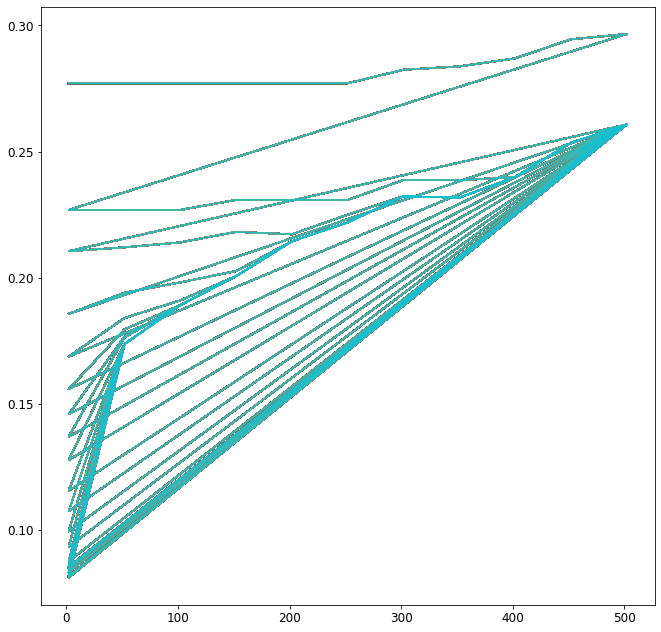

In [208]:
ax = plt.gca()

for i in range(len(results)):
    ax.plot(results["split"], results["RMSE"])
#    ax.plot(alphas, [coef[i] for coef in coefs], label=X_linear.columns[i])

Here again, we can build a dataframe for the particular variables that we want to include. Note that we do not standardize the variables. Why? Should we?

In [32]:
y_tree, X_tree = dmatrices('Obama_margin_percent ~ 0 + Region + ObamaHomeState + ClintonHomeState + MalesPer100Females + MedianIncome + UnemployRate + Age65andAbove+ White + Asian + Black + Hispanic + AmericanIndian + HighSchool + Poverty + PopDensity + Homeowner + FarmArea', elect_df_smaller_train, return_type="dataframe")

#Obama_margin_percent ~ Region + ObamaHomeState + ClintonHomeState + MalesPer100Females + MedianIncome + UnemployRate + Age65andAbove+ White + Asian + Black + Hispanic + AmericanIndian + HighSchool + Poverty + PopDensity + Homeowner + FarmArea', data=elect_df_train).fit()


Note that we have a `0 + ` in the above formula. This tells `patsy` to not create an intercept column. Intercepts aren't useful for tree based models (why?). We can see what it created:

In [67]:
X_tree

,Region[Midwest],Region[Northeast],Region[South],Region[West],Black,HighSchool,Poverty,PopDensity,SpeakingNonEnglish,LandArea
1677,0.0,0.0,1.0,0.0,5.4,76.0,6.6,27.0,3.0,267.0
594,0.0,0.0,1.0,0.0,40.3,70.1,18.2,40.0,3.6,406.0
642,0.0,0.0,1.0,0.0,12.5,75.3,10.5,76.9,2.9,219.0
1200,0.0,0.0,1.0,0.0,2.0,69.1,16.1,16.2,3.4,658.0
81,1.0,0.0,0.0,0.0,6.2,86.3,12.3,355.1,5.6,468.0
...,...,...,...,...,...,...,...,...,...,...
868,1.0,0.0,0.0,0.0,0.4,85.6,7.5,55.9,3.2,720.0
1377,0.0,0.0,1.0,0.0,17.7,65.4,20.6,20.1,3.3,541.0
1536,0.0,0.0,0.0,1.0,1.1,72.2,16.2,30.8,28.3,2791.0
1577,0.0,1.0,0.0,0.0,0.4,79.9,17.4,13.0,5.4,3255.0


In [68]:
y_tree

,Obama_margin_percent
1677,0.199231
594,0.399012
642,-0.020424
1200,-0.386296
81,0.188571
...,...
868,0.047990
1377,-0.142698
1536,-0.085749
1577,0.272727


Just like before, we create our `DecisionTreeRegressor` object. In the below, we just use the default values for all of the parameters.

In [33]:
dt = DecisionTreeRegressor()

We fit it to the data.

In [34]:
dt.fit(X_tree,y_tree)

DecisionTreeRegressor()

Now we can plot it to see what kind of decisions it made.

In [40]:
plt.figure(figsize=(20,20))
plot_tree(dt, feature_names=X_tree.columns, filled=True, fontsize=12)
plt.show()

KeyboardInterrupt: 

Well, that plot is a little hard to interpret. It seems like we might have too many splits. Let's take a look at the models performance.

Let's build our validation data like we've done before (remember we changed how we made the data for this model).

In [41]:
X_validation_tree = build_design_matrices([X_tree.design_info], elect_df_validation, return_type="dataframe")[0]

In [36]:
X_validation_tree

,Region[Midwest],Region[Northeast],Region[South],Region[West],ObamaHomeState,ClintonHomeState,MalesPer100Females,MedianIncome,UnemployRate,Age65andAbove,White,Asian,Black,Hispanic,AmericanIndian,HighSchool,Poverty,PopDensity,Homeowner,FarmArea
1700,0.0,0.0,1.0,0.0,0.0,0.0,82.4,30239.0,4.7,21.7,92.5,0.7,5.9,1.3,0.2,72.4,16.8,1356.3,65.1,263.877221
569,0.0,0.0,1.0,0.0,0.0,0.0,97.1,38428.0,4.0,12.6,97.5,0.4,1.2,1.1,0.4,67.0,12.3,93.3,80.3,28.000000
564,0.0,0.0,1.0,0.0,0.0,0.0,95.4,64514.0,4.1,9.1,80.8,3.4,14.0,2.9,0.3,87.9,6.8,368.6,82.1,23.000000
538,0.0,0.0,1.0,0.0,0.0,0.0,96.8,33786.0,4.2,13.2,87.9,0.4,11.0,2.8,0.2,66.0,17.2,37.0,75.4,126.000000
992,1.0,0.0,0.0,0.0,0.0,0.0,89.8,31765.0,6.7,19.5,98.1,0.2,0.8,0.9,0.4,80.0,14.6,20.7,76.9,340.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,1.0,0.0,0.0,0.0,0.0,0.0,98.6,51296.0,4.0,13.0,96.3,0.8,2.2,4.4,0.1,86.6,7.0,84.3,80.1,282.000000
1449,1.0,0.0,0.0,0.0,0.0,0.0,108.0,39705.0,2.3,17.0,98.2,0.3,0.1,31.8,0.4,72.0,9.5,24.5,75.2,244.000000
1062,0.0,1.0,0.0,0.0,0.0,0.0,95.1,74237.0,4.1,12.5,85.8,4.9,8.1,7.6,0.2,87.9,5.9,1346.1,74.6,47.000000
1172,0.0,0.0,1.0,0.0,0.0,0.0,97.0,29157.0,3.6,14.7,81.4,0.6,1.6,3.7,12.3,74.9,16.6,42.2,69.4,458.000000


Now we can predict on our validation set.

In [45]:
dt_pred = dt.predict(X_validation_tree)

In [46]:
accuracy(dt_pred, elect_df_validation["Obama_margin_percent"])

RMSE,MAE,R^2
0.193851,0.149289,0.608745


That is not great, but it's also a completely untuned decision tree. We can also look at the importance of various features using the below function.

In [76]:
def get_tree_importances(model, data):
    return pd.DataFrame({'Importance': model.feature_importances_}, index=data.columns).sort_values(['Importance'], ascending=False)

In [77]:
get_tree_importances(dt, X_tree)

,Importance
Black,0.303678
HighSchool,0.302807
Poverty,0.105613
PopDensity,0.081205
SpeakingNonEnglish,0.076971
LandArea,0.056817
Region[South],0.039853
Region[Northeast],0.022146
Region[West],0.008115
Region[Midwest],0.002795


These feature importances aren't as easy to interpret as coefficients of a linear regression, but they are a measure for how important each feature was in determing the final score.

Regression trees can be controlled (or tuned) to require that a tree can only split if there are sufficient samples in the resulting leaves and the total depth of the tree can be controlled. Both of these parameters are ways to avoid the most common ways in which decision trees overfit, which is by having too few samples in leaf nodes.

Play around with the below parameters. We will go more in depth with how to tune decision trees in a later case.

In [78]:
dt_tuned = DecisionTreeRegressor(min_samples_split=100, max_depth=5)

In [79]:
dt_tuned.fit(X_tree, y_tree)

DecisionTreeRegressor(max_depth=5, min_samples_split=100)

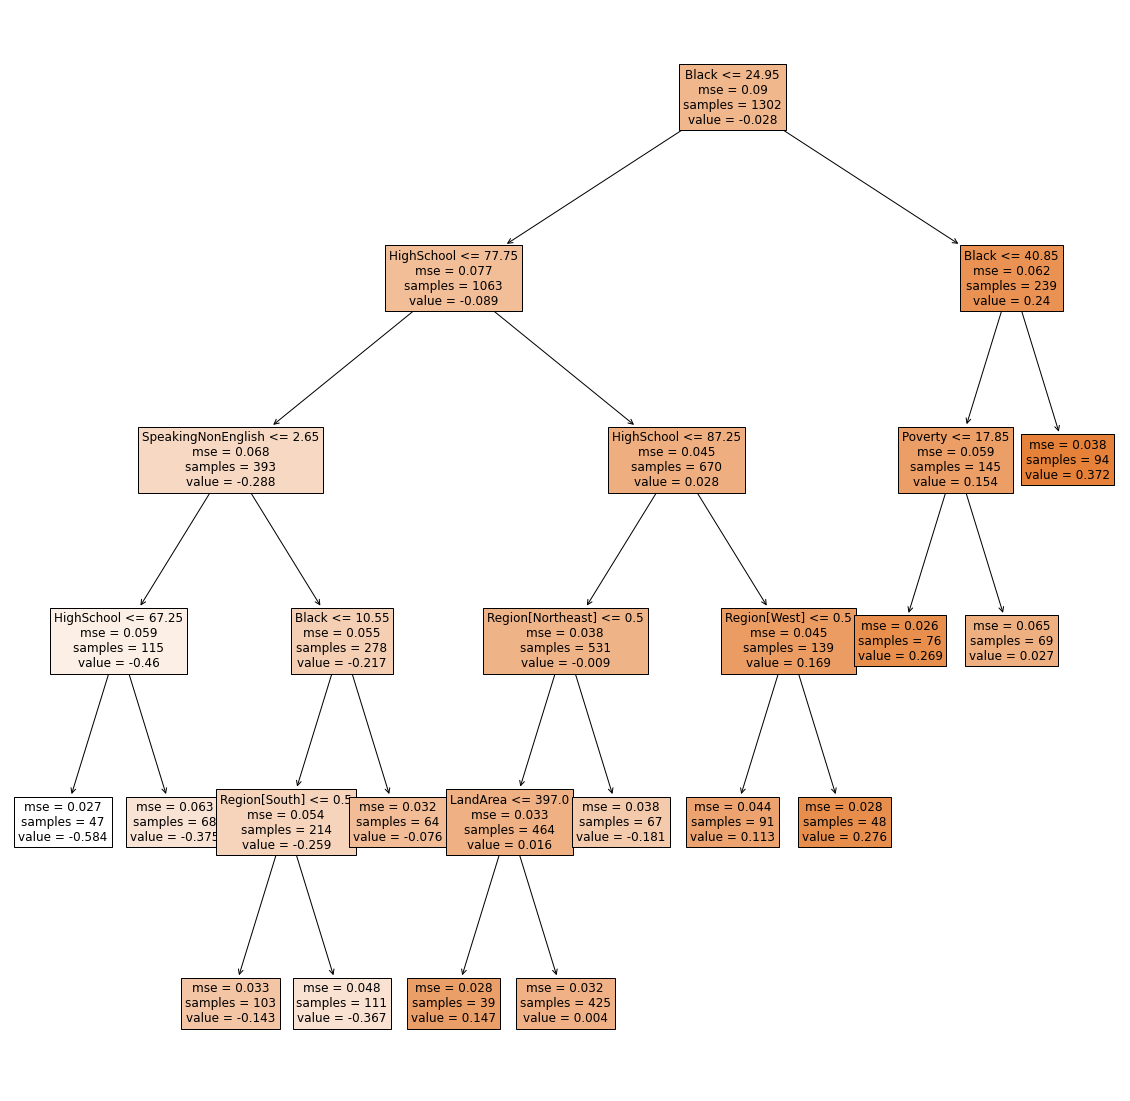

In [80]:
plt.figure(figsize=(20,20))
plot_tree(dt_tuned, feature_names=X_tree.columns, filled=True, fontsize=12)
plt.show()

That plot is easier to read. What insights can you draw from it?

In [88]:
dt_tuned_pred = dt_tuned.predict(X_validation_tree)

In [89]:
accuracy(dt_tuned_pred, elect_df_validation["Obama_margin_percent"])

RMSE,MAE,R^2
0.204271,0.162485,0.195355


It also does a little better on the validation data. We can also check feature importances:

In [90]:
get_tree_importances(dt_tuned, X_tree)

,Importance
HighSchool,0.431118
Black,0.371835
SpeakingNonEnglish,0.070540
Region[South],0.039214
Region[Northeast],0.033223
Poverty,0.031053
Region[West],0.012327
LandArea,0.010690
Region[Midwest],0.000000
PopDensity,0.000000
